This material is based upon work supported by the U.S. Department of Energy, Office of Science, Advanced Scientific Computing Research, Exploratory Research for Extreme-Scale Science program.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product


class NVQuantumSensing:
    def __init__(self, num_qubits, hyperfine_couplings=None, delta=0.0):
        """
        Initialize NV quantum sensing system

        Parameters:
        num_qubits: number of computational qubits (nuclear spins)
        hyperfine_couplings: array of hyperfine coupling strengths Ai (in kHz)
        delta: bare frequency splitting (in kHz)
        """
        self.num_qubits = num_qubits
        self.N = 2**num_qubits  # Total number of frequency bins

        # Default hyperfine couplings if not provided (based on typical NV-nuclear values)
        if hyperfine_couplings is None:
            # Use realistic values: strongest for 14N (~2.2 MHz), weaker for 13C
            if num_qubits >= 1:
                couplings = [2200.0]  # 14N coupling in kHz
                for i in range(1, num_qubits):
                    # 13C couplings, decreasing with distance
                    couplings.append(500.0 / (i**0.5))
            else:
                couplings = []
            self.hyperfine_couplings = np.array(couplings[:num_qubits])
        else:
            self.hyperfine_couplings = np.array(hyperfine_couplings)

        self.delta = delta

        # Generate all frequency bins
        self.frequencies = self._generate_frequency_bins()

    def _generate_frequency_bins(self):
        """Generate all 2^num_qubits frequency bins according to ωk = Δ + Σ((−1)^ki * Ai/2)"""
        frequencies = []

        # Generate all binary combinations
        for config in product([0, 1], repeat=self.num_qubits):
            freq = self.delta
            for i, ki in enumerate(config):
                freq += ((-1)**ki) * self.hyperfine_couplings[i] / 2
            frequencies.append(freq)

        return np.array(frequencies)

    def _driven_dissipative_evolution(self, B, T2, duration):
        """
        Calculate the evolution of a driven, dissipative two-level system

        Parameters:
        B: driving field strength (kHz)
        T2: dephasing time (μs)
        duration: evolution time (μs)

        Returns:
        prob_excited: probability of being in excited state |1⟩
        """
        # Dephasing rate
        gamma = 1.0 / T2

        # Rabi frequency
        omega_R = B

        # With dephasing, the excited state probability is approximately:
        # P_1(t) = sin^2(Ω_R * t / 2) * exp(-γt)

        effective_freq = np.sqrt(omega_R**2 + (gamma/2)**2)
        prob_excited = (omega_R / effective_freq)**2 * np.sin(effective_freq * duration / 2)**2 * np.exp(-gamma * duration)

        return min(prob_excited, 1.0)  # Ensure probability ≤ 1

    def calculate_detection_probabilities(self, signal_freq, B, T2, check_duration):
        """
        Calculate detection probabilities p_k^(k*) for all frequency bins

        Parameters:
        signal_freq: actual signal frequency (kHz)
        B: signal strength (kHz)
        T2: coherence time (μs)
        check_duration: duration of checking procedure (μs)

        Returns:
        probabilities: array of detection probabilities for each bin
        """
        probabilities = np.zeros(self.N)

        for k, freq_k in enumerate(self.frequencies):
            # Detuning from target frequency
            detuning = abs(signal_freq - freq_k)

            # Power broadening effect: effective driving strength decreases with detuning
            if detuning == 0:
                effective_B = B
            else:
                # Simple model: captures power broadening where off-resonant drives become less effective
                effective_B = B**3 / (B**2 + detuning**2)

            # Calculate detection probability using driven-dissipative evolution
            probabilities[k] = self._driven_dissipative_evolution(
                B=effective_B,
                T2=T2,
                duration=check_duration
            )

        return probabilities

    def calculate_grover_probabilities(self, signal_freq_index, B, T2, N_grover, BR0):
        """
        Calculate Grover search outcome probabilities G_k^(k*)

        Parameters:
        signal_freq_index: index of the actual signal frequency
        B: signal strength (kHz)
        T2: coherence time (μs)
        N_grover: number of Grover iterations
        BR0: strength of R0 gate driving field (kHz)

        Returns:
        grover_probs: probability distribution over measurement outcomes
        """
        # Duration of one Grover iteration
        sensing_oracle_time = 2 * np.pi / B  # μs
        R0_gate_time = 2 * np.pi / BR0  # μs
        hadamard_time = 0.1  # Assume fast Hadamard gates (μs)

        iteration_time = sensing_oracle_time + R0_gate_time + 2 * hadamard_time
        total_grover_time = N_grover * iteration_time

        # Simple decoherence model: success probability decreases exponentially
        decoherence_factor = np.exp(-total_grover_time / T2)

        # Ideal Grover success probability
        optimal_iterations = int(np.pi * np.sqrt(self.N) / 4)
        ideal_success_prob = np.sin((2 * N_grover + 1) * np.arcsin(1/np.sqrt(self.N)))**2

        # Actual success probability including decoherence
        success_prob = ideal_success_prob * decoherence_factor

        # Power broadening affects sensing oracle fidelity
        min_freq_spacing = np.min(np.diff(np.sort(self.frequencies)))
        power_broadening_factor = 1.0 / (1.0 + (B / min_freq_spacing)**2)
        success_prob *= power_broadening_factor

        # Probability distribution over outcomes
        grover_probs = np.ones(self.N) * (1 - success_prob) / (self.N - 1)
        grover_probs[signal_freq_index] = success_prob

        return grover_probs

    def calculate_improvement_factor(self, B_values, T2, optimize_grover=True):
        """
        Calculate improvement factor I as a function of signal strength B

        Parameters:
        B_values: array of signal strengths (kHz)
        T2: coherence time (μs)
        optimize_grover: whether to optimize number of Grover iterations

        Returns:
        improvement_factors: array of improvement factors
        """
        improvement_factors = []

        for B in B_values:
            # Duration parameters
            check_duration = np.pi / B  # π-pulse duration

            # BR0 parameter as given in the paper
            BR0 = 32 * 2**(-self.num_qubits) + 10 * np.sqrt(B / 1.0)  # kHz

            total_improvement = 0.0

            # Average over all possible signal frequencies (k*)
            # Use subset for computational efficiency
            sample_size = min(8, self.N)
            for k_star in range(sample_size):
                signal_freq = self.frequencies[k_star]

                # Calculate detection probabilities
                p_k = self.calculate_detection_probabilities(
                    signal_freq, B, T2, check_duration
                )

                # Conventional sensing time
                tau_conv = (np.pi / (2 * B)) * self.N / np.sum(p_k) if np.sum(p_k) > 0 else np.inf

                # Optimize Grover iterations if requested
                if optimize_grover:
                    best_tau_dqss = np.inf
                    max_iterations = min(int(np.pi * np.sqrt(self.N) / 2), 20)

                    for N_grover in range(1, max_iterations + 1):
                        # Calculate Grover probabilities
                        G_k = self.calculate_grover_probabilities(
                            k_star, B, T2, N_grover, BR0
                        )

                        # dQSS sensing time
                        grover_time = N_grover * (2 * np.pi / B + 2 * np.pi / BR0 + 0.2)

                        expected_checks = 1.0 / np.sum(G_k * p_k) if np.sum(G_k * p_k) > 0 else np.inf
                        tau_dqss = grover_time + check_duration * expected_checks

                        if tau_dqss < best_tau_dqss:
                            best_tau_dqss = tau_dqss
                else:
                    # Use near-optimal number of iterations
                    N_grover = max(1, int(np.pi * np.sqrt(self.N) / 4))
                    G_k = self.calculate_grover_probabilities(
                        k_star, B, T2, N_grover, BR0
                    )

                    grover_time = N_grover * (2 * np.pi / B + 2 * np.pi / BR0 + 0.2)
                    expected_checks = 1.0 / np.sum(G_k * p_k) if np.sum(G_k * p_k) > 0 else np.inf
                    best_tau_dqss = grover_time + check_duration * expected_checks

                # Calculate improvement for this signal frequency
                if best_tau_dqss > 0 and tau_conv > 0 and np.isfinite(tau_conv) and np.isfinite(best_tau_dqss):
                    improvement = tau_conv / best_tau_dqss
                else:
                    improvement = 1.0

                total_improvement += improvement

            # Average improvement factor
            avg_improvement = total_improvement / sample_size
            improvement_factors.append(avg_improvement)

        return np.array(improvement_factors)


B range: 1.0e-05 to 1.0e+01 kHz
T2 values: ['3e-03 s', '1e-02 s', '3e-02 s', '1e-01 s', '3e-01 s', '1e+00 s', '3e+00 s', '1e+01 s']
Computing T2 = 3e-03 s...
Computing T2 = 1e-02 s...
Computing T2 = 3e-02 s...
Computing T2 = 1e-01 s...
Computing T2 = 3e-01 s...
Computing T2 = 1e+00 s...
Computing T2 = 3e+00 s...
Computing T2 = 1e+01 s...


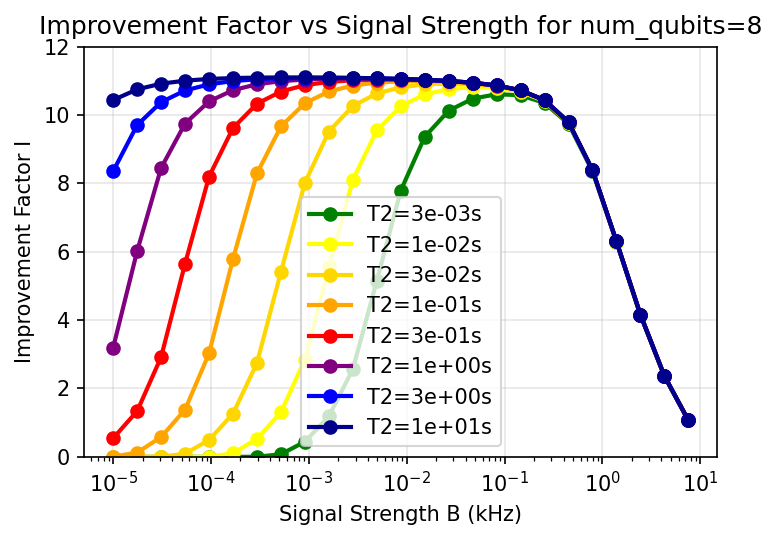

In [7]:
num_qubits = 8
B_values = np.logspace(-5, 1, 50)  # Signal strength
T2_values = [.003, .010, .030, .100, .300, 1, 3, 10]  # T2 from 10 ms to 10 s (in seconds)
T2_values_us = [t * 1e6 for t in T2_values]  # Convert to μs

print(f"B range: {B_values[0]:.1e} to {B_values[-1]:.1e} kHz")
print(f"T2 values: {[f'{t:.0e} s' for t in T2_values]}")

# Initialize NV system
nv_system = NVQuantumSensing(num_qubits=num_qubits)

# Calculate improvement factors for each T2
results = {}

for i, T2_us in enumerate(T2_values_us):
    print(f"Computing T2 = {T2_values[i]:.0e} s...")

    # Use subset of B values for faster computation
    B_subset = B_values[::2]  # Every 2nd point
    improvement = nv_system.calculate_improvement_factor(
        B_subset, T2_us, optimize_grover=True
    )

    results[T2_values[i]] = {
        'B_values': B_subset,
        'improvement': improvement,
        'T2_label': f'T2={T2_values[i]:.0e}s'
    }


plt.figure(figsize=(5, 3.7), dpi=150)

colors = ['green', 'yellow', 'gold', 'orange', 'red', 'purple', 'blue', 'darkblue', ]

for i, (T2, data) in enumerate(results.items()):
    plt.semilogx(data['B_values'], data['improvement'],
                'o-', color=colors[i], label=data['T2_label'], linewidth=2)

plt.xlabel('Signal Strength B (kHz)')
plt.ylabel('Improvement Factor I')
plt.title('Improvement Factor vs Signal Strength for num_qubits=8')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 12)
plt.tight_layout()
plt.show()